<a href="https://colab.research.google.com/github/Murcicrum/analisis-legislativo/blob/main/analisis_legislativo__primer_exploracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports y carga de datos

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab import drive


In [3]:
URL_CABECERA = 'https://github.com/Murcicrum/analisis-legislativo/raw/main/VotNom_cabecera.csv'
URL_DETALLES = 'https://github.com/Murcicrum/analisis-legislativo/raw/main/VotNom_detalles.csv'

df_cab = pd.read_csv( URL_CABECERA, index_col=0 )
df_det = pd.read_csv( URL_DETALLES, index_col=0 )

print( 'Shape de Cabecera: ',df_cab.shape)
print( 'Shape de Detalles: ',df_det.shape )

Shape de Cabecera:  (999, 21)
Shape de Detalles:  (256743, 7)


In [4]:
print('Columnas de Cabecera: \n', df_cab.columns)
print('\nColumnas de Detalles: \n', df_det.columns)

Columnas de Cabecera: 
 Index(['abstenciones', 'acta_id', 'ausentes', 'base_mayoria', 'fecha', 'hora',
       'nroperiodo', 'numero', 'persona_id', 'presidente_id',
       'presidente_nombre', 'resultado', 'reunion', 'sesion', 'sesion_id',
       'tipo_mayoria', 'tipo_periodo', 'tipo_sesion', 'titulo',
       'votos_afirmativos', 'votos_negativos'],
      dtype='object')

Columnas de Detalles: 
 Index(['acta_id', 'acta_detalle_id', 'diputado_nombre', 'persona_id', 'bloque',
       'distrito_nombre', 'voto'],
      dtype='object')


###Inspección de los datos faltantes

#### En el registro Cabecera

In [5]:
df_cab[ df_cab.isna().any(axis=1) ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 99
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abstenciones       999 non-null    int64  
 1   acta_id            999 non-null    int64  
 2   ausentes           999 non-null    int64  
 3   base_mayoria       999 non-null    object 
 4   fecha              999 non-null    object 
 5   hora               999 non-null    object 
 6   nroperiodo         999 non-null    int64  
 7   numero             999 non-null    int64  
 8   persona_id         0 non-null      float64
 9   presidente_id      0 non-null      float64
 10  presidente_nombre  999 non-null    object 
 11  resultado          999 non-null    object 
 12  reunion            999 non-null    int64  
 13  sesion             999 non-null    int64  
 14  sesion_id          999 non-null    object 
 15  tipo_mayoria       999 non-null    object 
 16  tipo_periodo       999 non-

En todas las entradas faltan los datos de 'presidente_id' y 'persona_id'. En la [documentación](https://www4.hcdn.gob.ar/Datos_doc/Documentaci%C3%B3n%20Votaciones%20Nominales.pdf) de estos registros no hay información sobre qué tipo de datos irían en esas columnas.

Veo cómo es la relación de actas con resultado afirmativo / negativo

In [6]:
df_cab.resultado.value_counts()

AFIRMATIVO    890
NEGATIVO      109
Name: resultado, dtype: int64

El registro está muy desbalanceado, teniendo que casi el ~90% de las actas en votación resultan aprobadas.

####En el registro Detalles

Veo los nans en el registro detallado

In [7]:
df_det[ df_det.isna().any(axis=1) ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 30840 to 25443
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   acta_id          162 non-null    int64 
 1   acta_detalle_id  162 non-null    int64 
 2   diputado_nombre  0 non-null      object
 3   persona_id       162 non-null    object
 4   bloque           57 non-null     object
 5   distrito_nombre  162 non-null    object
 6   voto             162 non-null    object
dtypes: int64(2), object(5)
memory usage: 10.1+ KB


Hay 162 filas con NaNs, en todas ellas falta el diputado_nombre, y en 105 falta el bloque

In [8]:
df_det[ df_det.bloque.isna() ].diputado_nombre.value_counts( dropna=False )

NaN    105
Name: diputado_nombre, dtype: int64

En todas las que falta el bloque falta el nombre del diputado.

Cómo figuran los votos de esos nans:

In [9]:
df_det[ df_det.diputado_nombre.isna() ].voto.value_counts()

AUSENTE    162
Name: voto, dtype: int64

Cuántos diputados faltan en las votaciones de las actas

In [10]:
df_det.groupby(['acta_id']).diputado_nombre.agg('count').value_counts()

257    864
256    126
253      9
Name: diputado_nombre, dtype: int64

En la mayoría de las votaciones están presentes los 257 diputados, pero en 9 actas hay 253 (faltan 4) y en 126 hay 256 (falta 1).

# Análisis exploratorio

Cuántas actas se votaron en cada periodo

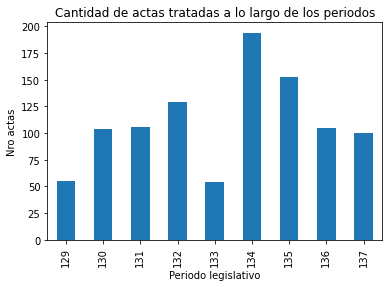

In [11]:
acts_x_period = df_cab.groupby('nroperiodo').size()
acts_x_period.plot( kind='bar',
                    xlabel='Periodo legislativo', ylabel='Nro actas', title='Cantidad de actas tratadas a lo largo de los periodos')

Dado que en cada acta hay 257 votos, esta distribución es también la del número de votos emitidos en cada periodo

*   A lo largo de los periodos

In [12]:
df_merged = pd.merge(df_cab, df_det, on='acta_id', how='left')

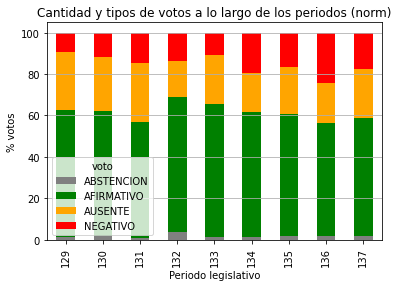

In [13]:
vots_x_nroperiod = pd.pivot_table( df_merged, values='acta_id', 
                                   columns=['voto'], index=['nroperiodo'] , 
                                   aggfunc=np.count_nonzero )

vots_x_nroperiod = vots_x_nroperiod.apply( lambda x: x*100/sum(x), axis=1)

vots_x_nroperiod.plot( kind='bar', stacked=True, 
                       ylabel='% votos', xlabel='Periodo legislativo', title='Cantidad y tipos de votos a lo largo de los periodos (norm)',
                       color=['gray','g','orange','r'])
plt.grid(axis='y')

Se vé que en todos estos periodos la porción de abstenciones no supera el 5% de los votos y que para los afirmativos ronda el 60%. Mientras que en el los últimos 4 periodos legislativos (entre los años 2015~2019) hay un leve aumento en los votos negativos y una leve disminución en las ausencias. 

De esto se desprende que hay un gran desbalance en los distintos tipos de votos, con excepción del par AUSENTE-NEGATIVO que tienen una relación similar. El acumulado durante todos los periodos sería:

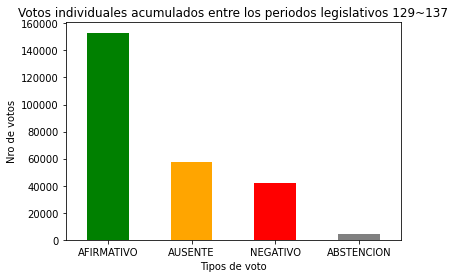

In [14]:
df_det.voto.value_counts().plot( kind='bar',
                                 xlabel='Tipos de voto', ylabel='Nro de votos', title='Votos individuales acumulados entre los periodos legislativos 129~137',
                                 color=['g','orange','r','gray'], rot=0 )

Cómo impacta este desbalance de votos individuales en los resultados finales de las votaciones

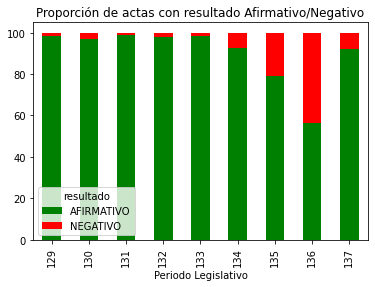

In [15]:
results_x_nroperiodo = pd.pivot_table( df_cab, values='acta_id', 
                                       index='nroperiodo', columns=['resultado'], 
                                       aggfunc='count' )

results_x_nroperiodo = results_x_nroperiodo.apply( lambda x: x*100/sum(x), axis=1 )

results_x_nroperiodo.plot(kind='bar', stacked='True',
                          xlabel='Periodo Legislativo', title='Proporción de actas con resultado Afirmativo/Negativo',
                          color=['g','r'] )

En los últimos 4 periodos legislativos, la porción de actas rechazadas aumenta, alcanzando el máximo en el periodo 136. Cabe recordar que en el periodo 136 y 137 la cantidad de actas fué casi idéntica.

El acumulado a lo largo de todos los periodos sería:

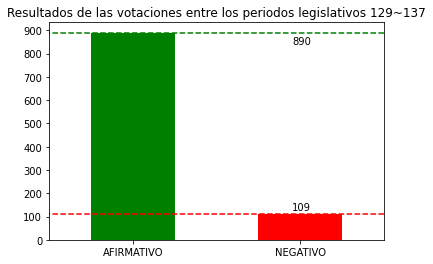

In [16]:
df_cab.resultado.value_counts().plot( kind='bar',
                                      title='Resultados de las votaciones entre los periodos legislativos 129~137',
                                      color=['g','r'], rot=0)

tot_afirms, tot_negats = df_cab.resultado.value_counts()

plt.hlines(y=tot_afirms, xmin=-1,xmax=2, colors='g', linestyles='dashed')
plt.hlines(y=tot_negats, xmin=-1,xmax=2, colors='r', linestyles='dashed')

plt.text(x=0.95, y=tot_negats+20, s=f'{tot_negats}')
plt.text(x=0.95, y=tot_afirms-50, s=f'{tot_afirms}')

plt.yticks([ 100*n for n in range(0,10) ]);

Viendo esto, la probabilidad de que un acta arbitraria resulte aprobada (AFIRMATIVA) sería del 89.1%.

Esto plantea una dificultad adicional al problema de entrenar un modelo clasificador que prediga el resultado de una elección en la cámara baja, puesto que sesgaría las predicciones hacia el lado de las actas aprobadas.

La otra dificultad que se presenta para dicho fin, es que la mayoría de los features presentes en el registro Cabecera no aporta información directa sobre el acta a ser tratada ni su resultado. Quizás la única excepción a esto es el feature 'titulo'.

In [17]:
df_cab.titulo[100:125].tolist()

['Expediente 7-PE-2018 - O.D. 984. Artículo 6.',
 'Moción propuesta por el diputado LOUSTEAU, Martín',
 'Apartamiento de reglamento propuesto por la diputada TUNDIS, Mirta',
 'Ley "Micaela", de capacitación obligatoria en género para todas las personas que integran los tres poderes del Estado. Establecimiento.',
 'Expediente 93-S-2018 Votacion General y Particular',
 'Expediente 4294-D-2016 - Orden del Día 1287 - Votación en General y Particular.',
 'Expediente 0149-S-2015 - Orden del Día 912. Votación en General.',
 'Expediente 1295-D-2017 - Orden del Día 1288 - Votación en General.',
 'Expediente 0017-S-2017. Votación en General y Particular.',
 'Expediente 0016-S-2017 - Votación en General y Particular',
 'Expediente 0125-S-2016 Orden del Dia 1289 - Votación en General y Particular',
 'Expediente 54-S-2016 - Orden del Dia 907 - Votación en General y Particular',
 'Expediente 29-PE-2016 - Orden del Día 910 - Votación en General y Particular',
 'Expediente 47-S-2016 - Orden del Día 12

Pero también se ve que casi todas de las veces el título del acta no dice explicitamente qué cuestiones están en votación sino que refieren a un expediente donde, asumo, se especificarán dichas cuestiones.


Cómo se distribuyen los resultados bajo las otras características de la sesión:

*   Sobre el tipo de mayoría



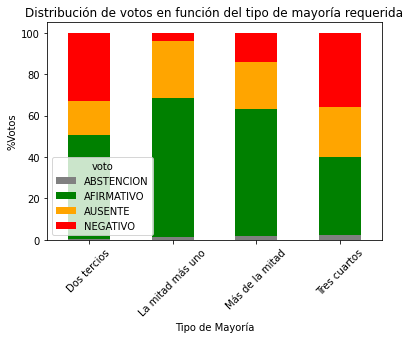

In [18]:
vots_x_mayoria = pd.pivot_table(df_merged, values='acta_id', columns=['voto'],
                                aggfunc=np.count_nonzero, index='tipo_mayoria')

vots_x_mayoria = vots_x_mayoria.apply( lambda x: x*100/sum(x), axis=1)

vots_x_mayoria.plot( kind='bar', stacked=True,
                     xlabel='Tipo de Mayoría', ylabel='%Votos', title='Distribución de votos en función del tipo de mayoría requerida',
                     color=['gray','g','orange','r'], rot=45 )

Hay una diferencia apreciable en la proporción de votos afirmativos y negativos para los distintos tipos de mayoría. Para los tipos 'Mitad más uno' y 'Más de la mitad' la porción de votos negativos es significativamente menor que la de positivos, mientras que para 'Dos tercios' y 'Tres cuartos' (que son los tipos que más cantidad de diputados presentes requieren) hay similar cantidad de votos positivos y negativos.

*    Sobre el tipo de sesion 

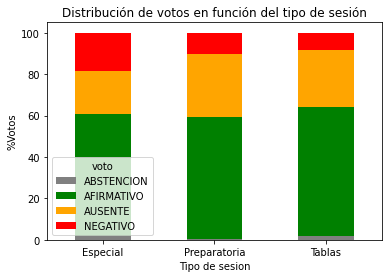

In [19]:
vots_x_sesion = pd.pivot_table( df_merged, values='acta_id', 
                                columns=['voto'], index='tipo_sesion', 
                                aggfunc=np.count_nonzero )

vots_x_sesion = vots_x_sesion.apply( lambda x: x*100/sum(x), axis=1)

vots_x_sesion.plot( kind='bar', stacked=True,
                    xlabel='Tipo de sesion', ylabel='%Votos', title='Distribución de votos en función del tipo de sesión',
                    color=['gray','g','orange','r'], rot=0)

results_x_sesion = pd.pivot_table( df_merged, values='acta_id', 
                                columns=['resultado'], index='tipo_sesion', 
                                aggfunc=np.count_nonzero )

En el tipo de sesión 'Especial' hay un leve aumento de los votos positivos respecto de las ausencias. Más allá de esto las distribuciones de los demás votos es practicamente igual para los otros tipos de sesión y voto.

Y esto repercute sobre los resultados finales de la votación como:

In [20]:
df_cab.groupby(['tipo_sesion','resultado']).size()

tipo_sesion   resultado 
Especial      AFIRMATIVO    689
              NEGATIVO       96
Preparatoria  AFIRMATIVO      1
Tablas        AFIRMATIVO    200
              NEGATIVO       13
dtype: int64



*    Sobre el tipo de periodo

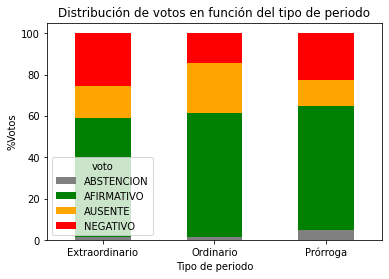

In [21]:
vots_x_tipperiodo = pd.pivot_table( df_merged, values='acta_id', 
                                    columns=['voto'], index=['tipo_periodo'], 
                                    aggfunc=np.count_nonzero )

vots_x_tipperiodo = vots_x_tipperiodo.apply( lambda x: x*100/sum(x), axis=1 )

vots_x_tipperiodo.plot( kind='bar', stacked=True,
                        xlabel='Tipo de periodo', ylabel='%Votos', title='Distribución de votos en función del tipo de periodo',
                        color=['gray','g','orange','r'], rot=0 )

La porción de votos afirmativos es relativamente constante en todos los tipos de periodo, y para el tipo 'Ordinario' la relación de ausente-negativo se revierte.

#Calculador de coincidencias

Una pregunta que me parece interesante hacer es: Cuánta afinidad hay entre los diputados que integran la Cámara a los largo de los periodos? De eso se trata lo que viene a continuación.
Para contabilizar y contestar la pregunta de alguna forma, se me ocurrión calcular cuánto coinciden pares de diputados a lo largo de todo un periodo legislativo. Concretamente, para un periodo dado, y un par de diputados $d_i,d_j$ calculo un índice $c_{ij}$ en la forma
 


$$c_{ij}=\frac{\sum^{\#actas}{coinc(d_i,d_j)}}{\#actas}$$

donde

$$
coinc(d_i,d_j)=
\begin{cases}1 \;\;\; si \;\;\;voto(d_i) = voto(d_j)
\\0 \;\;\; si \;\;\;voto(d_i)\not= voto(d_j)
\end{cases}
$$


Notese que esto dá como resultado una matríz simétrica, ya que $coinc(d_i,d_j)=coinc(d_j,d_i)$, que un coeficiente $c_{ij}$ será, por ejemplo, igual a 1 sólo si el par de diputados $d_i,d_j$ votan de forma idéntica a lo largo de todo el periodo o 0 sólo si nunca votaron de la misma, y que sobre la diagonal siempre se tendrá el valor máximo, puesto que un diputado coincide con si mismo el 100% de las veces.
Se espera entonces que para diputados de igual ideología estos valores sean muy cercanos a 1, mientras que si tienen ideologías opuestas serán cercanos a 0, pasando por suepuesto por todos los valores intermedios que indicarían cierto nivel de concordancia entre ellos.

#####Calculo de coincidencias

In [22]:
sorted_periods = df_cab.nroperiodo.unique().copy()
sorted_periods.sort()

coincidencias_d = []
cortes_d = []

d_peract = {}
print('Calculando coincidencias...')

for periodo in sorted_periods:

  print('\tPeriodo ', periodo)

#Guardo las actas que se trataron en ese periodo
  actas = df_cab[ df_cab['nroperiodo']==periodo ].acta_id.unique()
#y cuantas hubo, para poder normalizar al final
  d_peract[periodo] = len(actas)
  
#Guardo los nombres de todos los diputados activos en esas actas
#ordenados por el nombre del bloque que representan


  df_aux = df_det[ df_det.acta_id.isin( actas ) ]#.sort_values(by='bloque',ignore_index=True)
  
  df_aux['freq'] = df_aux.groupby('bloque')['bloque'].transform('count')
  
  df_aux.sort_values(['freq','bloque'], ascending=False, ignore_index=True, inplace=True)
  df_aux.dropna( inplace=True )
  
  df_aux['nro_bloque'] = [ np.where( df_aux.freq.unique() == f )[0][0] for f in df_aux.freq ]
  
  diputs = df_aux.diputado_nombre.unique()

  cant_diputs = len( diputs )
  
  values = []
  
  for d in diputs:
    values.append( (d,
                    df_aux[ df_aux.diputado_nombre==d ].bloque.unique()[0],
                    df_aux[ df_aux.diputado_nombre==d ].nro_bloque.unique()[0] ) )

  dipbloqs = pd.DataFrame( data=values, columns=['nombre','bloque','nro_bloque'] )
  cortes = dipbloqs[:-1].iloc[ dipbloqs.bloque.to_numpy()[1:] != dipbloqs.bloque.to_numpy()[:-1] ]
  cortes_per = []
  for i,b in zip(cortes.index, cortes.bloque):
    cortes_per.append( (i,b) )



#Calculo de las coincidencias en cada acta
  coincidencias_per = np.zeros( shape=(cant_diputs,cant_diputs) )

  for n, act in enumerate(actas):                                                 #Para cada acta
    
    df_act = df_det[ df_det.acta_id == act ]                                      #Armo un dataframe auxiliar sólo de esa acta

#Busco las coincidencias en ese periodo
    for voto in ['AFIRMATIVO', 'NEGATIVO', 'AUSENTE', 'ABSTENCION']:              #Por cada tipo de voto posible
      coinc_diputs = df_act[ df_act.voto==voto ].diputado_nombre                  #Levanto los nombres de diputados que tengan el mismo tipo de voto

      coinc_indexs = np.asarray([ np.where(diputs==cd)[0][0] for cd in coinc_diputs       #Me fijo en que indice de diputs está cada uno de esos diputados
                                                              if type(cd)!=float ])       #los nombres son str, pero los NaN los guarda como floats y quiero descartarlos

#LLeno la matriz
      for i, ind in enumerate( coinc_indexs ):                                    #Por cada indice 'ind' en la lista de indices de coincidencias

        for ond in coinc_indexs[i:]:                                              #Saco otro indice 'ond' de los últimos i indices. Esto es así para no repetir cuentas, porque la matriz es simétrica
          if ind == ond:                                                          #Si saqué dos indices iguales, i.e. si estoy sobre la diagonal, lo omito y paso al siguiente
            pass                                                                  #Lo puse así porque sino se satura la diagonal
            #coincidencias[ind,ind] += 1
          else:                                                                   #Si saqué dos indices distintos
            coincidencias_per[ind,ond] += 1                                           #sumo uno en esos lugar de la matriz de coincidencias
            coincidencias_per[ond,ind] += 1

#Normalizo por la cantidad de actas en ese periodo  
  coincidencias_per = coincidencias_per/d_peract[periodo]

  cortes_d.append( cortes_per )
  coincidencias_d.append( coincidencias_per )

Calculando coincidencias...
	Periodo  129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  130


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

Notese que para realizar estos calculos se ordenó a los diputados (asignandoles los índices $i=0,1,2,...256$) no por sus nombres alfabéticos sino por el número de votos que se emitieron desde el bloque / partido político que integraban, lo que es directamente proporcional a la cantidad de diputados que forman dicho bloquese. De esta forma se gana una intuición de qué nivel de concordancia hay entre los distintos bloques.


#####Visualización de matrices

Text(0.5, 0.98, 'Coincidencias entre diputados de cada periodo \ny número de diputados en los 10 bloques más grandes')

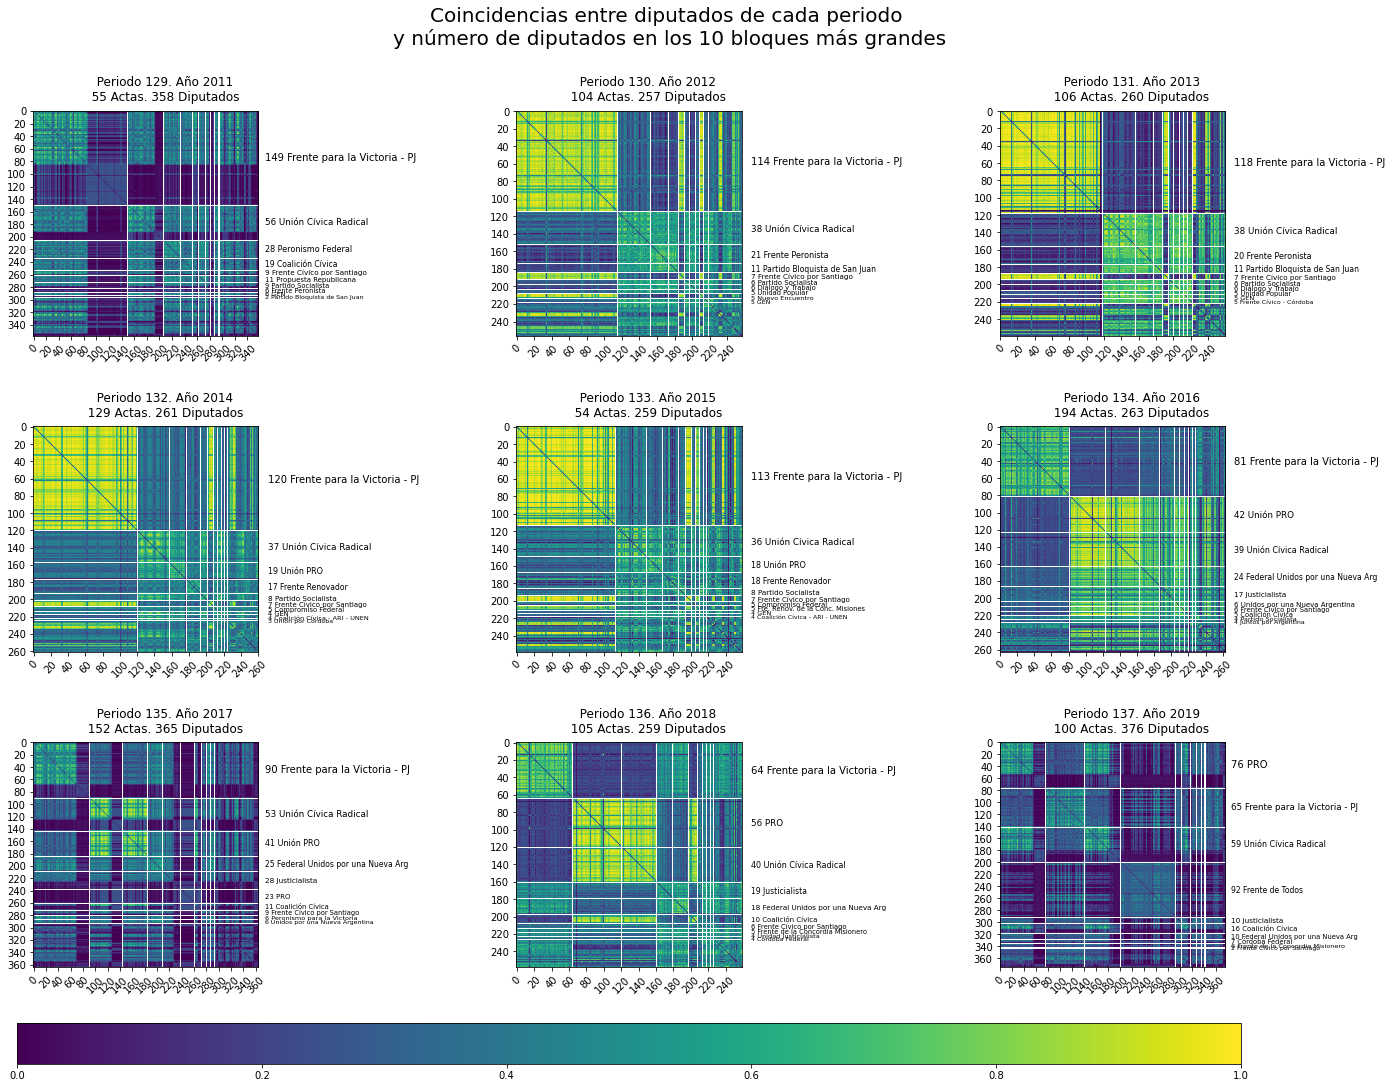

In [23]:
fig, axs = plt.subplots( 3,3, constrained_layout=True, figsize=(20,15))

for i, [ax, matriz, cortes] in enumerate(zip( axs.ravel(), coincidencias_d, cortes_d )):
  
  im = ax.imshow( matriz )
  
  title = f'''
          Periodo {sorted_periods[i]}. Año {sorted_periods[i]+1882}
          {d_peract[sorted_periods[i]]} Actas. {matriz.shape[0]} Diputados
           '''
  ax.set_title( title, fontsize=12, y=0.95)
  ax.set_xticks( range(0,matriz.shape[0], 20) )
  ax.set_yticks( range(0,matriz.shape[0], 20) )
  ax.tick_params(axis='x', labelrotation = 45 )


  cortes = [(0,'')] + cortes
  for n in range(1,11):
    ax.text( s=f'{cortes[n][0]-cortes[n-1][0]} {cortes[n][1]}'[:35], fontsize=10/n**0.2,
             x=matriz.shape[0]+10, y=(cortes[n-1][0]+cortes[n][0])/2+4)

    ax.vlines( cortes[n][0] ,0,matriz.shape[0]-1, colors='w', linewidths=1)
    ax.hlines( cortes[n][0] ,0,matriz.shape[0]-1, colors='w', linewidths=1)

fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.9, orientation='horizontal')
fig.suptitle('Coincidencias entre diputados de cada periodo \ny número de diputados en los 10 bloques más grandes', fontsize='20')
  #fig.savefig(f'comportamiento_bloques_{sorted_periods[i]}-{sorted_periods[i]+1882}')

Como consecuencia del orden asignado a los diputados, sobre la diaglonal se forman cuadrados que representan a todo un bloque y ahora cobra sentido pensar no en diputados en filas y columnas, sino en bandas horizontales y verticales de partidos políticos, donde la intersección de dos bandas da cuenta del nivel de cooperación (voluntario o involuntario) que hay entre ellos. Calculando los coeficientes de esta forma los gráficos correspondientes a los periodos (impares) donde se renueva una porción de la camara suelen aparecer de forma desprolija debido mayormente a los cambios de nombres en la lista de diputados que suceden; o bien a los cambios de nombre de los bloques, como es el caso del último periodo donde el PRO aparece en 1er lugar ya que el FpV cambió de nombre por el de FdT apareciendo como dos bloques distintos. Una última salvedad es que a aproximadamente a partir del 10mo bloque, estos están formados por sólo 4, 3, 2 o 1 diputado, por lo que distinguirlos es complicado.



Hay bastantes cosas interesantes que se pueden observar a partir de estos gráficos. La principal es que se cumple la sospecha acerca de los diputados que integran un mismo bloque y los que están en bloques de ideoligía opuesta, los niveles de coincidencias son cercanos a 1 y 0 respectivamente. Lo segundo, y creo yo más importante, es que a grandes rasgos hay una estructura que se repite a lo largo de todos los periodos: el bloque mayoritario tiene muy bajas coincidencias para con el 2do y 3er bloque, los cuales a su vez cooperan mucho entre sí. Las coincidencias para los próximos 2 o 3 bloques es más variable, pudiendo estar estos muy en sintonía con el bloque mayoritario o con los dos siguientes, pero no con ambos. Y los bloques pequeños, con a lo sumo 7 u 8 representantes ya parecerían ser mas conciliatorios con los 3 bloques más grandes, sin decantarse por ninguno en particular o con una preferencia no muy determinante.

#Presentación del problema y nuevo enfoque

Pese al desbalance en el registro Cabecera entre entradas de actas con resultado Afirmativo/Negativo en una proporción 9:1, me propongo predecir el resultado de una votación. Para ello voy a utilizar algunos de los features sobre la sesión que considero clave: el número de periodo y su tipo, el tipo de sesión y tipo de mayoría requerida para la votación; y agregando además nuevos features que den cuenta de la estructura que encontré anteriormente.

Estos features vendrán de a pares para cada bloque: uno será un _índice de presencia_ en (0,1) que indique qué porcentaje de los diputados de ese bloque está presente para emitir su voto, y el otro será un _índice de apoyo_ en (-1,1) que promediará el voto de todos los diputados presentes en dicho bloque, considerando como +1 un voto positivo, 0 una abstención y -1 un voto negativo. Monitoreo así por separado la participación activa de cada bloque y también la presencia puesto que es sábido que la ausencia de los diputados en una votación es algo que se utiliza como herramienta política para entorpecer y/o suspender una votación.

Por último también incluyo un nuevo feature categórico que indique si el bloque mayoritario es oficialismo u oposición en esa votación.

Ahora bien, incluir estos nuevos features que miden la presencia de cada bloque y el voto promedio que emiten a un acta para predecir el resultado final de la votación no es muy distinto de hacer una suma aritmética con todos los votos emitidos individualmente, lo cual hace trivial la predicción. La "dificultad" que quiero a agregar al problema es la de sólo considerar algunos de los bloques mayoritarios, lo que en cierta forma introduce la preguntas ¿pueden sólo estos bloques mayormente polarizados determinar el resultado de una elección? ¿Cuánto peso tienen estos y cuánto los bloques pequeños más mediadores?.

Veamos primero cómo son estos parámetros para los primeros 10 bloques mayoritarios.

##Comportamiento de bloques, presencia y apoyo

In [24]:
apoyos_x_actas = []

N_BLOQUES_MAYORITARIOS = 10

for j,acta in enumerate(df_cab.acta_id):

  df_acta = df_det[ df_det.acta_id==acta ]

  bloques_mayoritarios = df_acta.bloque.value_counts().index[:N_BLOQUES_MAYORITARIOS]

  apoyos = {}
#un poco de info sobre el acta
  apoyos['acta_id'] = acta
  
  periodo = df_cab[ df_cab.acta_id==acta ].nroperiodo.values[0]
  
  #Si el bloque mayoritario pertenece al oficialismo
  bloque_principal = bloques_mayoritarios[0]
  #Considerando que en periodo133/año2015 el PJ era oficialista, para ser consitente debo considerarlo oposición en el periodo137/año2018
  es_oficialismo = periodo <= 133 and bloque_principal=='Frente para la Victoria - PJ'
  if es_oficialismo:  apoyos['es_oficialismo'] = 1
  else:               apoyos['es_oficialismo'] = 0

#Calculo los indices de apoyo y presencia de los bloques mayoritarios
  for i,bloque in enumerate( bloques_mayoritarios ):

    votos_total     = len( df_acta[ (df_acta.bloque==bloque) ] )
    votos_afirmativo= len( df_acta[ (df_acta.bloque==bloque) & (df_acta.voto=='AFIRMATIVO') ] )
    votos_negativo  = len( df_acta[ (df_acta.bloque==bloque) & (df_acta.voto =='NEGATIVO' ) ] )
    votos_ausente   = len( df_acta[ (df_acta.bloque==bloque) & (df_acta.voto == 'AUSENTE' ) ] )

    presencia = ( votos_total - votos_ausente )   /  votos_total
    if presencia:
      apoyo = (votos_afirmativo - votos_negativo )  /  ( votos_total - votos_ausente )
    else: 
      apoyo = None

    apoyos[f'b{str(i+1)}_presencia'] = presencia
    apoyos[f'b{str(i+1)}_apoyo'] = apoyo
  
  apoyos_x_actas.append( apoyos )

Meto esto en un nuevo dataset para poder manejarlo más cómodamente

In [59]:
df_apoyos = pd.DataFrame(data = apoyos_x_actas )
df_apoyos

,acta_id,es_oficialismo,b1_presencia,b1_apoyo,b2_presencia,b2_apoyo,b3_presencia,b3_apoyo,b4_presencia,b4_apoyo,b5_presencia,b5_apoyo,b6_presencia,b6_apoyo,b7_presencia,b7_apoyo,b8_presencia,b8_apoyo,b9_presencia,b9_apoyo,b10_presencia,b10_apoyo
0,3761,0,0.676923,0.977273,0.981818,-1.000000,0.950000,-1.000000,0.526316,1.0,0.764706,1.0,1.000000,-1.0,0.833333,0.6,0.800000,1.0,1.00,1.0,0.75,1.0
1,3762,0,0.753846,0.918367,0.890909,1.000000,0.975000,1.000000,0.736842,1.0,0.882353,1.0,0.900000,1.0,0.666667,1.0,1.000000,1.0,1.00,1.0,0.50,0.0
2,3763,0,0.830769,1.000000,0.927273,1.000000,0.975000,1.000000,0.736842,1.0,0.882353,1.0,0.900000,1.0,0.833333,1.0,1.000000,1.0,1.00,1.0,0.50,1.0
3,3764,0,0.753846,1.000000,0.927273,1.000000,0.950000,1.000000,0.631579,1.0,0.882353,1.0,0.900000,1.0,0.833333,1.0,1.000000,1.0,1.00,1.0,0.75,1.0
4,3765,0,0.830769,-1.000000,0.963636,1.000000,0.950000,1.000000,0.736842,1.0,0.941176,-1.0,1.000000,1.0,0.833333,1.0,1.000000,1.0,0.75,1.0,0.75,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,3959,0,0.983333,1.000000,0.764706,-1.000000,0.808511,-1.000000,0.800000,-1.0,0.750000,1.0,0.666667,1.0,0.666667,1.0,0.500000,-1.0,1.00,1.0,0.50,1.0
995,3960,0,0.932773,1.000000,0.745098,1.000000,0.936170,1.000000,1.000000,1.0,0.500000,1.0,0.666667,1.0,1.000000,1.0,0.666667,1.0,1.00,1.0,1.00,1.0
996,3961,0,0.915966,1.000000,0.666667,0.529412,0.893617,-0.547619,0.933333,-1.0,0.500000,1.0,0.666667,1.0,1.000000,1.0,0.666667,1.0,1.00,1.0,1.00,1.0
997,3962,0,0.907563,1.000000,0.666667,1.000000,0.893617,1.000000,0.866667,1.0,0.500000,1.0,0.666667,1.0,1.000000,1.0,0.666667,1.0,1.00,1.0,1.00,1.0


####nueva exploración

In [26]:
df_apoyos[[ c for c in df_apoyos.columns if c.endswith('apoyo') ]].describe()

,b1_apoyo,b2_apoyo,b3_apoyo,b4_apoyo,b5_apoyo,b6_apoyo,b7_apoyo,b8_apoyo,b9_apoyo,b10_apoyo
count,992.000000,947.000000,942.000000,938.000000,987.000000,917.000000,893.000000,973.000000,922.000000,923.000000
mean,0.577525,0.390771,0.371505,0.543285,0.650534,0.673469,0.580403,0.669887,0.540781,0.451192
std,0.786122,0.886671,0.898792,0.763214,0.700235,0.707492,0.769620,0.710664,0.811069,0.848958
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.913043,-0.937500,-1.000000,0.291667,0.846154,1.000000,0.750000,1.000000,0.500000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df_apoyos[[ c for c in df_apoyos.columns if c.endswith('presencia') ]].describe()

,b1_presencia,b2_presencia,b3_presencia,b4_presencia,b5_presencia,b6_presencia,b7_presencia,b8_presencia,b9_presencia,b10_presencia
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.817336,0.778418,0.740368,0.651655,0.749691,0.748568,0.658830,0.771271,0.698849,0.715465
std,0.170758,0.227079,0.266969,0.257467,0.206497,0.291918,0.324556,0.240199,0.276176,0.293019
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.723077,0.707317,0.700000,0.521739,0.647059,0.666667,0.500000,0.666667,0.600000,0.500000
50%,0.861538,0.857143,0.833333,0.705882,0.750000,0.833333,0.800000,0.800000,0.750000,0.750000
75%,0.947368,0.926829,0.915780,0.842105,0.882353,1.000000,1.000000,1.000000,0.833333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#####Histogramas

Text(0.5, 1, 'Comportamiento de los primeros bloques mayoritarios\nen los periodos 129~137 (2011~2019)')

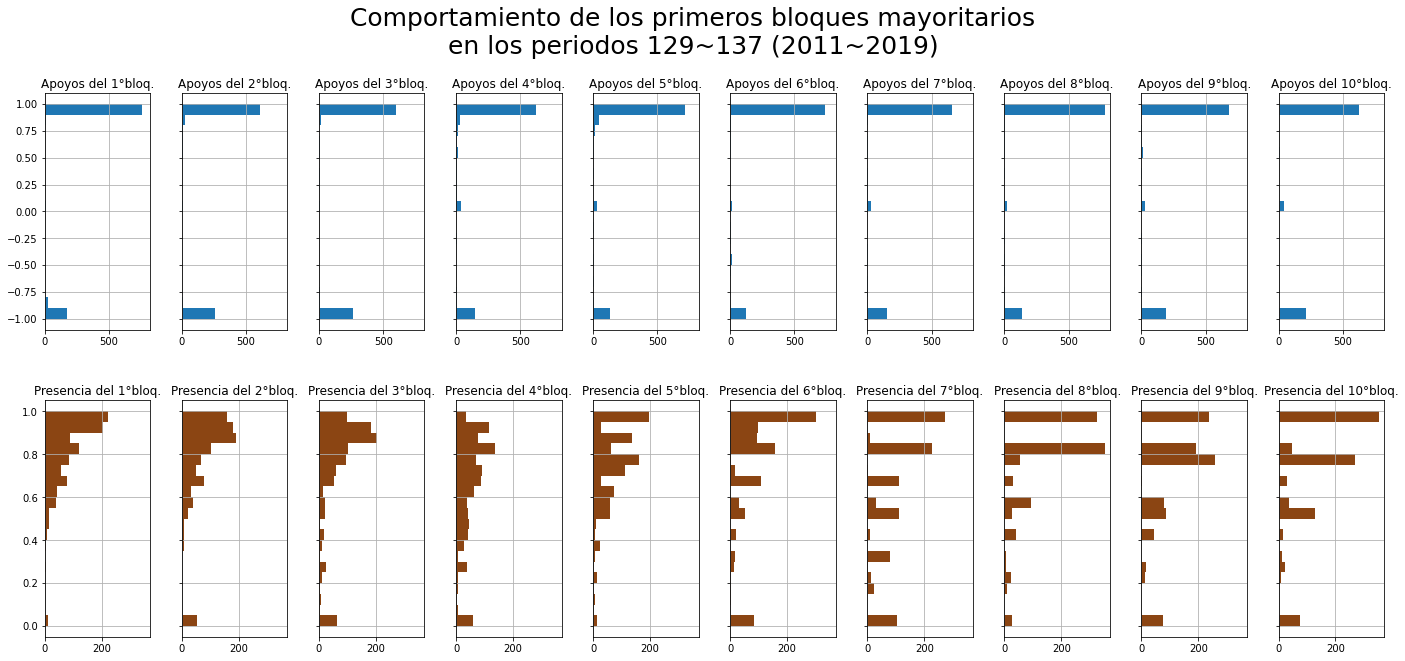

In [28]:
#Horizontal
fig, axs = plt.subplots( 2,10, sharex='row', sharey='row', figsize=(24,10))

for i in range(10):

#  df_apoyos.hist(column=f'b{i+1}_apoyo', bins=20,
#                 orientation='horizontal', ax=axs[0,i])
#  axs[0,i].set_title( f'Apo. del {i+1}° bloque' )
  df_apoyos.hist(column=f'b{i+1}_apoyo', bins=20,
                 orientation='horizontal', ax=axs[0,i])
  axs[0,i].set_title( f'Apoyos del {i+1}°bloq.' )
 
  df_apoyos.hist(column=f'b{i+1}_presencia', bins=20, 
                 orientation='horizontal', ax=axs[1,i], color='saddlebrown')
  axs[1,i].set_title( f'Presencia del {i+1}°bloq.' )

fig.suptitle(t='Comportamiento de los primeros bloques mayoritarios\nen los periodos 129~137 (2011~2019)',
             fontsize=25, y=1)
#fig.savefig('comportamiento_mayoritarios.png')


Respecto a la primer fila de histogramas que ilustra el _índice de apoyo_, notese que el bloque con más diputados dá entre 3 y 4 veces más votos positivos que negativos; mientras que el segundo y tercero dan aproximadamente 2 veces más apoyo positivo que negativo. A su vez es practicamente nula su neutralidad en los votos ya que no se aprecia que haya cuentas para valores cercanos a 0, lo que ocurriría si buena parte de los diputados se abstienen de votar o si emiten votos positivos y negativos en igual proporción. Esto sí es algo que ocurre para los bloques siguientes donde la neutralidad como bloque empieza a ser apreciable, aunque sea mucho menor frente a las alternativas de apoyar o rechazar un acta.

Sobre el _índice de presencia_ se vé que el 1er bloque tiene los nieveles de presencia más altos, siendo esta casi siempre mayor al 50%. Algo similar ocurre para el 2do bloque, salvo por una excepción que también se dá en los bloques siguientes: en estos es mucho más frecuente la ausencia del total de sus miembros. Y también en estos empieza a haber más variedad respecto del porcentaje de representantes presentes en las votaciones, aunque lo más frecuente es que todos estén presentes.

#####Matrices de correlación

Cómo se correlacionan los _índices de apoyo_ y _presencia_ entre los distintos bloques. Analizo esto en función de la correlación de Spearman.

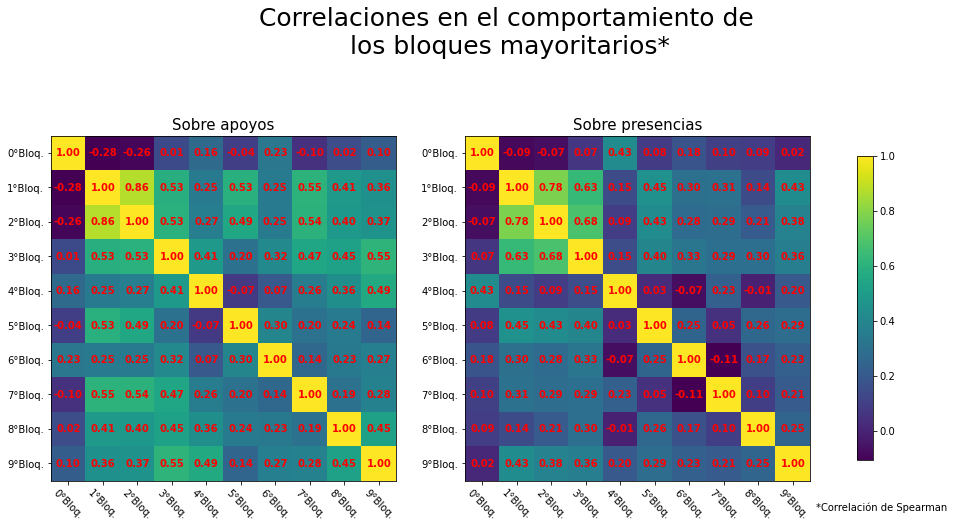

In [29]:
fig, axs = plt.subplots( 1,2, figsize=(17,7))


apoyo_matcorr = df_apoyos[[ c for c in df_apoyos.columns if c.endswith('_apoyo') ]]
apoyo_matcorr = apoyo_matcorr.corr(method='spearman') #type = pd.DataFrame
apoyo_pltcorr = axs[0].imshow( apoyo_matcorr )
for i in range(len(apoyo_matcorr)):
  for j in range(len(apoyo_matcorr)):
    axs[0].text(i,j, f'{apoyo_matcorr.to_numpy()[i,j]:.2f}',
                ha='center', va='center', color='r', fontweight='bold')

axs[0].set_title( 'Sobre apoyos', fontsize=15)


presencia_matcorr = df_apoyos[[ c for c in df_apoyos.columns if c.endswith('_presencia') ]]
presencia_matcorr = presencia_matcorr.corr(method='spearman')
presencia_pltcorr= axs[1].imshow( presencia_matcorr)
for i in range(len(presencia_matcorr)):
  for j in range(len(presencia_matcorr)):
    axs[1].text(i,j, f'{presencia_matcorr.to_numpy()[i,j]:.2f}',
                ha='center', va='center', color='r', fontweight='bold')

axs[1].set_title( 'Sobre presencias', fontsize=15 )



ticks = [n  for n in range(10) ]
tick_labels = [ f'{t}°Bloq.' for t in ticks ]
axs[0].set_xticks( ticks )
axs[0].set_xticklabels( tick_labels )
axs[0].tick_params(axis='x',labelrotation=-45)
axs[0].set_yticks( ticks )
axs[0].set_yticklabels( tick_labels )
axs[1].set_xticks( ticks )
axs[1].set_xticklabels( tick_labels )
axs[1].tick_params(axis='x',labelrotation=-45)
axs[1].set_yticks( ticks )
axs[1].set_yticklabels( tick_labels )



fig.suptitle('Correlaciones en el comportamiento de \nlos bloques mayoritarios*',
             fontsize=25, y=1.1)
fig.text(x=0.75,y=0.1, s='*Correlación de Spearman')
fig.colorbar(presencia_pltcorr, ax=axs.ravel().tolist(), orientation='vertical',shrink=0.8)
fig.savefig('comportamiento_correlaciones.png')

En estas imágenes queda sintetizada la estructura encontrada periodo a periodo, donde se veía que el primer bloque no compartía coincidencias con los dos siguientes, que estos dos a su vez colaboraban mucho entre sí, y la actividad de los bloques siguientes no solía estar alineada a una u otra de las tres primeras de forma tan brusca.

Visualizo la distribución de estas variables para verificar si no hay algun otro tipo de relación entre pares de variables con baja correlación de Spearman.

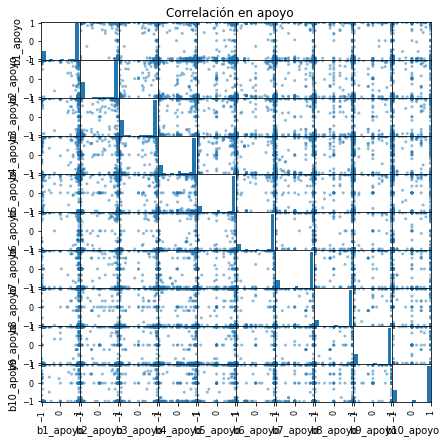

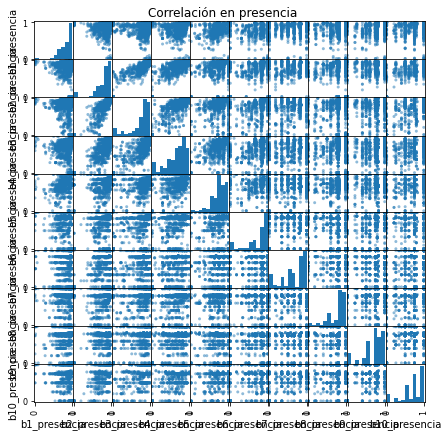

In [30]:
for tipo in ['_apoyo', '_presencia']:
  pd.plotting.scatter_matrix(df_apoyos[[ c for c in df_apoyos.columns if c.endswith(tipo)]], 
                             figsize=(7,7))
  plt.suptitle(f'Correlación en {tipo[1:]}', y=0.91 )


No se vé otro tipo de relaciones entre pares de variables con baja correlación de Spearman.


Tampoco se observa correlación entre pares de _apoyo_-_presencia_ para un mismo bloque:

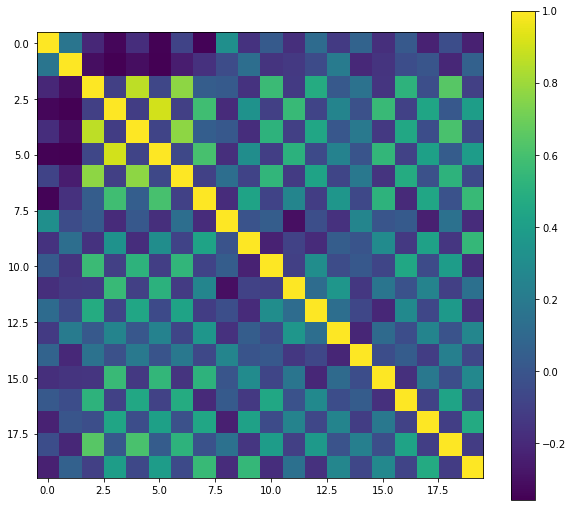

In [31]:
plt.figure( figsize=(10,10) )

matcorr = df_apoyos[[ c for c in df_apoyos.columns if c not in ['acta_id', 'nroperiodo', 'es_oficialismo'] ]].corr()
pltcorr = plt.imshow( matcorr )
plt.colorbar(pltcorr, shrink=0.9)

#for i in range(len(matcorr)):
#  for j in range(len(matcorr)):
#    plt.text(i,j, f'{matcorr.to_numpy()[i,j]:.2f}',
#             ha='center', va='center', color='r', fontweight='bold')

#Los ticks van como 1_presencia,1_apoyo,2_presencia,2_apoyo....

In [32]:
#Para incluir la variable 'nro de actas a votar en cada sesión'
#
#df_cab['id_sesion'] = df_cab['nroperiodo'].astype(str)+'_'+df_cab['sesion'].astype(str)
#df_cab['actas_x_sesion'] = df_cab.groupby('id_sesion')['id_sesion'].transform('count')
#df_cab.drop('id_sesion', axis=1, inplace=True)
#
#sns.histplot(data=df_cab, x='actas_x_sesion', hue='resultado', 
#             stat='density')

# Construcción del dataset final

En vista de todo el análisis previo, elijo sólo considerar la presencia y apoyo de los primeros 4 bloques mayoritarios, lo que equivaldría a descartar la participación de más de un tercio de los diputados que conforman los bloques más pequeños. Ya agrego también tres características de la sesión que considero claves: el Tipo de mayoría y el número y tipo de periodo, lo que dá una medida del año y més en el que suceden las votaciones.

In [55]:
print('Columnas de Cabecera \n', df_cab.columns)
print('\nColumnas de Apoyos \n', df_apoyos.columns)

Columnas de Cabecera 
 Index(['abstenciones', 'acta_id', 'ausentes', 'base_mayoria', 'fecha', 'hora',
       'nroperiodo', 'numero', 'persona_id', 'presidente_id',
       'presidente_nombre', 'resultado', 'reunion', 'sesion', 'sesion_id',
       'tipo_mayoria', 'tipo_periodo', 'tipo_sesion', 'titulo',
       'votos_afirmativos', 'votos_negativos'],
      dtype='object')

Columnas de Apoyos 
 Index(['acta_id', 'es_oficialismo', 'b1_presencia', 'b1_apoyo', 'b2_presencia',
       'b2_apoyo', 'b3_presencia', 'b3_apoyo', 'b4_presencia', 'b4_apoyo',
       'b5_presencia', 'b5_apoyo', 'b6_presencia', 'b6_apoyo', 'b7_presencia',
       'b7_apoyo', 'b8_presencia', 'b8_apoyo', 'b9_presencia', 'b9_apoyo',
       'b10_presencia', 'b10_apoyo'],
      dtype='object')


In [64]:
COLS_CAB = [ 'acta_id', 'nroperiodo', 'tipo_periodo', 'tipo_mayoria','resultado' ]

COLS_APO = [ 'acta_id', 'es_oficialismo', 'b1_presencia', 'b1_apoyo', 'b2_presencia', 
            'b2_apoyo', 'b3_presencia', 'b3_apoyo', 'b4_presencia', 'b4_apoyo']

df_final = pd.merge(left=df_apoyos[COLS_APO], right=df_cab[COLS_CAB], 
                    on='acta_id', how='inner').copy()

In [65]:
df_final

,acta_id,es_oficialismo,b1_presencia,b1_apoyo,b2_presencia,b2_apoyo,b3_presencia,b3_apoyo,b4_presencia,b4_apoyo,nroperiodo,tipo_periodo,tipo_mayoria,resultado
0,3761,0,0.676923,0.977273,0.981818,-1.000000,0.950000,-1.000000,0.526316,1.0,136,Ordinario,Dos tercios,NEGATIVO
1,3762,0,0.753846,0.918367,0.890909,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
2,3763,0,0.830769,1.000000,0.927273,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
3,3764,0,0.753846,1.000000,0.927273,1.000000,0.950000,1.000000,0.631579,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
4,3765,0,0.830769,-1.000000,0.963636,1.000000,0.950000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,3959,0,0.983333,1.000000,0.764706,-1.000000,0.808511,-1.000000,0.800000,-1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO
995,3960,0,0.932773,1.000000,0.745098,1.000000,0.936170,1.000000,1.000000,1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO
996,3961,0,0.915966,1.000000,0.666667,0.529412,0.893617,-0.547619,0.933333,-1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO
997,3962,0,0.907563,1.000000,0.666667,1.000000,0.893617,1.000000,0.866667,1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO


Finalmente guardo el dataset 

In [67]:
df_final.to_csv('dataset_final.csv')